# Timeseries Foundation Model Experiment

## Original Paper: "Deep spatio-temporal residual networks for citywide crowd flows prediction"

https://arxiv.org/pdf/1610.00081

The goal is to predict one step ahead

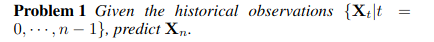

### Datasets

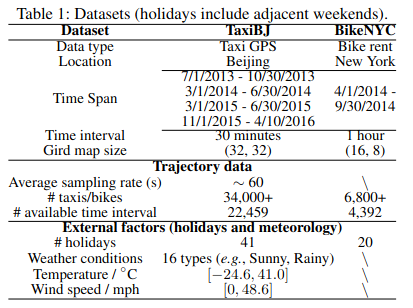

* TaxiBJ: the last four weeks as the testing data, and all data before that as training data.
* BikeNYC: the last 10 days are chosen as testing data, and the others as training data.

### Results

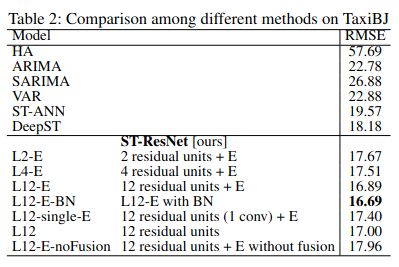
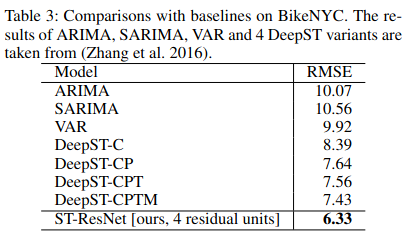

## Experiment

In [56]:
# [dataset]
data_files = ["./datasets/BikeNYC/NYC14_M16x8_T60_NewEnd.h5"]
holiday_file = ""
meteorol_file = ""
T = 24  # time step of one hour
len_closeness = 3
len_period = 1
len_trend = 1
period_interval = 1
trend_interval = 7
len_test = 672
use_meta = True

# [model]
nb_flow = 2
map_height = 8
map_width = 16
nb_residual_unit = 4

# [learning]
epochs = 50
batch_size = 32
learning_rate = 0.0002


In [57]:
import tables
import numpy as np

In [58]:
def remove_incomplete_days(dat: tables.file.File, T: int) -> tuple[np.ndarray, np.ndarray]:
    # 20140425 has 24 timestamps, which does not appear in `incomplete_days` in the original implementation.
    # So I reimplemented it in a different way.
    data = dat.root.data.read()
    timestamps = dat.root.date.read().astype(str)

    dates, values = np.vstack(
        np.frompyfunc(lambda x: (x[:8], x[8:]), 1, 2)(timestamps)
    )
    # label encoding
    uniq_dates, labels = np.unique(dates, return_inverse=True)
    # groupby("labels")["values"].sum() != sum(range(1, 49))
    incomplete_days = uniq_dates[
        np.where(np.bincount(labels, values.astype(int)) != sum(range(1, (T + 1))))[
            0
        ]
    ]
    del_idx = np.where(np.isin(dates, incomplete_days))[0]
    new_data = np.delete(data, del_idx, axis=0)
    new_timestamps = np.delete(timestamps, del_idx)
    return new_data, new_timestamps

In [59]:
dat=tables.open_file(data_files[0],mode="r")
data=dat.root.data.read()
data

array([[[[ 0.,  0.,  1., ...,  0.,  0.,  0.],
         [ 0.,  1.,  1., ...,  1.,  0.,  0.],
         [ 0.,  0.,  2., ...,  2.,  2.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  3.,  1.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  1.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  1.,  0.,  0.],
         [ 0.,  0.,  0., ...,  1.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  1.,  0.],
         [ 0.,  0.,  0., ...,  2.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],


       [[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  1.,  2.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  1.,  0.,  1.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  1., ..., 

In [60]:
datasets = remove_incomplete_days(dat,T)
datasets

(array([[[[ 0.,  0.,  1., ...,  0.,  0.,  0.],
          [ 0.,  1.,  1., ...,  1.,  0.,  0.],
          [ 0.,  0.,  2., ...,  2.,  2.,  0.],
          ...,
          [ 0.,  0.,  0., ...,  3.,  1.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  1.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  1.,  0.,  0.],
          [ 0.,  0.,  0., ...,  1.,  0.,  0.],
          ...,
          [ 0.,  0.,  0., ...,  0.,  1.,  0.],
          [ 0.,  0.,  0., ...,  2.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],
 
 
        [[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0., ...,  0.,  1.,  2.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  1.,  0.,  1.]],
 
         [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
          [ 0.,  0.,  0., ...,  0.,  0.,  0.],
   

In [61]:
datasets[1]

array(['2014040101', '2014040102', '2014040103', ..., '2014093022',
       '2014093023', '2014093024'], dtype='<U10')

In [62]:
def extract_timeseries(data: np.ndarray, row: int, col: int, channel: int = 0) -> np.ndarray:
    """
    Extracts the time series of a specific grid location from a 4D numpy array.
    
    Parameters:
        data (np.ndarray): A 4D numpy array with shape (time_steps, channels, height, width)
        row (int): The row index of the desired grid location
        col (int): The column index of the desired grid location
        channel (int): The channel index to extract from (default: 0)
        
    Returns:
        np.ndarray: A 1D array representing the time series at the specified location
    """
    if data.ndim != 4:
        raise ValueError("Input data must be a 4D numpy array (time_steps, channels, height, width)")
    
    if not (0 <= row < data.shape[2]) or not (0 <= col < data.shape[3]):
        raise ValueError("Row or column index out of bounds")
    
    if not (0 <= channel < data.shape[1]):
        raise ValueError("Channel index out of bounds")
    
    return data[:, channel, row, col]

grid_data = datasets[0]

ROW=3
COL=5

# Extract time series from row 5, column 3 in channel 0
time_series = extract_timeseries(grid_data, row=ROW, col=COL, channel=0)

print(time_series)


[0. 1. 0. ... 2. 4. 1.]


In [63]:
len(time_series)

4392

In [64]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


In [65]:

def adjust_timestamps(timestamps):
    """
    Adjusts the given timestamps by subtracting 1 hour from each entry.
    
    Parameters:
        timestamps (numpy array): Array of timestamps in 'YYYYMMDDHH' format.
        
    Returns:
        numpy array: Adjusted timestamps.
    """
    adjusted = []
    for ts in timestamps:
        # Fix invalid '24' hour case
        if ts[-2:] == '24':
            ts = (datetime.strptime(ts[:8], "%Y%m%d") + timedelta(days=1)).strftime("%Y%m%d") + "00"
        dt = datetime.strptime(ts, "%Y%m%d%H") - timedelta(hours=1)
        adjusted.append(dt.strftime("%Y%m%d%H"))
    
    return np.array(adjusted, dtype='<U10')

# Example usage
timestamps = datasets[1]
timestamps = adjust_timestamps(timestamps)
timestamps

array(['2014040100', '2014040101', '2014040102', ..., '2014093021',
       '2014093022', '2014093023'], dtype='<U10')

In [66]:
def format_timestamp(timestamp: str) -> str:
    """
    Converts timestamp from 'YYYYMMDDHH' to 'YYYY-MM-DD HH:00'.
    
    Parameters:
        timestamp (str): A string representing the timestamp in 'YYYYMMDDHH' format.
        
    Returns:
        str: Formatted timestamp as 'YYYY-MM-DD HH:00'.
    """
    dt = datetime.strptime(timestamp, "%Y%m%d%H")
    return dt.strftime("%Y-%m-%d %H:00")

def create_dataframe(timeseries: np.ndarray, timestamps: np.ndarray) -> pd.DataFrame:
    """
    Creates a pandas DataFrame from the extracted time series and timestamps.
    
    Parameters:
        timeseries (np.ndarray): A 1D numpy array representing the time series
        timestamps (np.ndarray): A 1D numpy array of timestamps corresponding to the time series
        
    Returns:
        pd.DataFrame: A DataFrame containing timestamps and values
    """
    if timeseries.shape[0] != timestamps.shape[0]:
        raise ValueError("Time series and timestamps must have the same length")

    formatted_timestamps = [format_timestamp(ts) for ts in timestamps]

    df = pd.DataFrame({
        'timestamp': formatted_timestamps,
        'value': timeseries
    })
    return df


df = create_dataframe(time_series, timestamps)
print(df)

             timestamp  value
0     2014-04-01 00:00    0.0
1     2014-04-01 01:00    1.0
2     2014-04-01 02:00    0.0
3     2014-04-01 03:00    0.0
4     2014-04-01 04:00    1.0
...                ...    ...
4387  2014-09-30 19:00   16.0
4388  2014-09-30 20:00   10.0
4389  2014-09-30 21:00    2.0
4390  2014-09-30 22:00    4.0
4391  2014-09-30 23:00    1.0

[4392 rows x 2 columns]


Get the last 10 days for validation, like in the paper (+5 as input):

In [67]:
train_data_df = df[df['timestamp']<'2014-09-21 00:00']

In [68]:
test_data_df = df.copy()

In [69]:
df = df[df['timestamp']>='2014-09-16 00:00']

### AutoGluon

In [2]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [70]:
train_data_df['item_id']=1
test_data_df['item_id']=1

In [71]:
test_data = TimeSeriesDataFrame.from_data_frame(
    test_data_df,
    id_column="item_id",
    timestamp_column="timestamp"
)
test_data.head()

value
item_id timestamp                 
1       2014-04-01 00:00:00    0.0
        2014-04-01 01:00:00    1.0
        2014-04-01 02:00:00    0.0
        2014-04-01 03:00:00    0.0
        2014-04-01 04:00:00    1.0

In [72]:
train_data = TimeSeriesDataFrame.from_data_frame(
    train_data_df,
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data.head()

value
item_id timestamp                 
1       2014-04-01 00:00:00    0.0
        2014-04-01 01:00:00    1.0
        2014-04-01 02:00:00    0.0
        2014-04-01 03:00:00    0.0
        2014-04-01 04:00:00    1.0

In [83]:
predictor = TimeSeriesPredictor(
    prediction_length=1,
    path="autogluon-bikenyc",
    target="value",
    eval_metric="RMSE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/home/anita/Documents/Github/ST-ResNet/autogluon-bikenyc'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #57-Ubuntu SMP PREEMPT_DYNAMIC Wed Feb 12 23:42:21 UTC 2025
CPU Count:          16
GPU Count:          0
Memory Avail:       54.07 GB / 62.64 GB (86.3%)
Disk Space Avail:   728.07 GB / 1876.71 GB (38.8%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'value',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'h'


In [84]:
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


,,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
item_id,timestamp,,,,,,,,,,
1,2014-09-21,1.754033,-2.148267,-0.322958,0.230935,1.122046,1.846594,2.699208,3.319965,4.805785,7.575176


In [85]:
import matplotlib.pyplot as plt
predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4);

In [86]:
predictor.eval_metric

RMSE

In [87]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Theta,-1.159327,-0.689775,14.230979,13.781039,0.010335,6
1,WeightedEnsemble,-1.164678,-0.000048,14.266418,13.793585,0.496255,9
2,TemporalFusionTransformer,-1.165467,-0.101715,0.034468,0.012546,63.979439,8
3,DirectTabular,-2.162155,-1.590111,0.081103,0.067480,0.456886,4
4,Chronos[bolt_small],-2.933263,-1.512945,1.203953,0.865748,0.010645,7
5,Naive,-3.000000,-2.000000,0.710423,0.920255,0.010190,1
6,ETS,-5.370389,-2.081574,1.486668,1.436984,0.010500,5
7,RecursiveTabular,-5.973798,-2.374812,0.030330,0.028561,0.493181,3
8,SeasonalNaive,-8.000000,-4.000000,0.015438,0.720150,0.009513,2


In [ ]:
rmse = predictor.evaluate(test_data)['RMSE']*-1
rmse

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


1.1646778030862528

#### Run forecasts for all grid cells

In [96]:
def compute_cell_rmse(row, col):
    time_series = extract_timeseries(grid_data, row=row, col=col, channel=0)
    timestamps = datasets[1]
    timestamps = adjust_timestamps(timestamps)
    df = create_dataframe(time_series, timestamps)
    df['item_id']=1
    train_data = TimeSeriesDataFrame.from_data_frame(
        df[df['timestamp']<'2014-09-21 00:00'],
        id_column="item_id",
        timestamp_column="timestamp"
    )
    test_data = TimeSeriesDataFrame.from_data_frame(
        df,
        id_column="item_id",
        timestamp_column="timestamp"
    )

    predictor = TimeSeriesPredictor(prediction_length=1, path="autogluon-bikenyc", target="value", eval_metric="RMSE")
    predictor.fit(train_data, presets="medium_quality", time_limit=600)
       
    rmse = predictor.evaluate(test_data)['RMSE']*-1
    print(f"[{row},{col}] RMSE:{rmse}")
    return rmse

rmses =  []

for row in range(0,16):
    for col in range(0,8):
        rmses.append(compute_cell_rmse(row,col))

print(rmses)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/home/anita/Documents/Github/ST-ResNet/autogluon-bikenyc'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #57-Ubuntu SMP PREEMPT_DYNAMIC Wed Feb 12 23:42:21 UTC 2025
CPU Count:          16
GPU Count:          0
Memory Avail:       53.84 GB / 62.64 GB (86.0%)
Disk Space Avail:   728.08 GB / 1876.71 GB (38.8%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 1,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'value',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'h'


[0,0] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.73    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.74    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.5s of the 598.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.38    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.3s of the 596.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.33    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 118.7s of the 593.7s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.15    s     = Validation (predi

[0,1] RMSE:0.0


	-0.0187       = Validation score (-RMSE)
	0.56    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.3s of remaining time.
	-0.2902       = Validation score (-RMSE)
	0.90    s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.3s of remaining time.
	-0.2182       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.32    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.5s of the 598.0s of remaining time.
	-1.0510       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.2s of the 597.7s of remaining time.
	-0.8455       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.81    s     = Validation (predicti

[0,2] RMSE:3.265546883536473


	-6.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.72    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.3s of remaining time.
	-1.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.6s of the 599.2s of remaining time.
	-0.8460       = Validation score (-RMSE)
	0.48    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.8s of the 598.7s of remaining time.
	-6.0229       = Validation score (-RMSE)
	0.42    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.6s of the 598.2s of remaining time.
	-1.2131       = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.42    s     = Validation (predi

[0,3] RMSE:0.746910567796272


	-2.7089       = Validation score (-RMSE)
	0.69    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.2s of remaining time.
	-3.8091       = Validation score (-RMSE)
	0.61    s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.5s of remaining time.
	-3.9997       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.33    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.5s of the 598.2s of remaining time.
	-7.7225       = Validation score (-RMSE)
	0.01    s     = Training runtime
	13.86   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 194.8s of the 584.3s of remaining time.
	-5.0811       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.83    s     = Validation (predicti

[0,4] RMSE:1.6496429443359375


	0.0000        = Validation score (-RMSE)
	2.32    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.37    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.18    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 594.9s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.55    s     = Validation (predicti

[0,5] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.50    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.4s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.45    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 594.9s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.02    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.7s of the 594.8s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.18    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.2s of the 594.6s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.64    s     = Validation (predicti

[0,6] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.73    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.79    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.5s of the 598.4s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.37    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.3s of the 596.0s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.46    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 118.7s of the 593.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.39    s     = Validation (predi

[0,7] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.40    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.38    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.0s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.7s of the 595.0s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 594.8s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.63    s     = Validation (predicti

[1,0] RMSE:0.0


	-2.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.74    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.74    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.5s of the 598.5s of remaining time.
	-1.1913       = Validation score (-RMSE)
	0.59    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.8s of remaining time.
	-2.6068       = Validation score (-RMSE)
	0.40    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.5s of the 597.4s of remaining time.
	-0.8439       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.67    s     = Validation (predi

[1,1] RMSE:6.0


	-1.9304       = Validation score (-RMSE)
	0.47    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-2.1992       = Validation score (-RMSE)
	0.46    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.9s of remaining time.
	-2.2224       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.67    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.5s of the 598.2s of remaining time.
	-2.3005       = Validation score (-RMSE)
	0.01    s     = Training runtime
	13.57   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 194.9s of the 584.6s of remaining time.
	-0.8409       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.64    s     = Validation (predicti

[1,2] RMSE:1.441439151763916


	-6.7710       = Validation score (-RMSE)
	0.63    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.3s of remaining time.
	-14.0180      = Validation score (-RMSE)
	0.57    s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.6s of remaining time.
	-10.8355      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.33    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.3s of remaining time.
	-16.6179      = Validation score (-RMSE)
	0.01    s     = Training runtime
	13.68   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 194.9s of the 584.6s of remaining time.
	-11.2846      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.61    s     = Validation (predicti

[1,3] RMSE:13.644144058227539


	-1.1849       = Validation score (-RMSE)
	0.61    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.3s of remaining time.
	-3.2392       = Validation score (-RMSE)
	0.45    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.7s of remaining time.
	-2.5083       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.32    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.4s of remaining time.
	-1.8857       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.2s of remaining time.
	-1.7528       = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.97    s     = Validation (predicti

[1,4] RMSE:0.5165963182513398


	-3.3436       = Validation score (-RMSE)
	0.62    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.3s of remaining time.
	-4.2641       = Validation score (-RMSE)
	0.45    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.7s of remaining time.
	-2.1408       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.4s of remaining time.
	-1.8566       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.33    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.1s of remaining time.
	-1.7097       = Validation score (-RMSE)
	0.02    s     = Training runtime
	0.82    s     = Validation (predicti

[1,5] RMSE:2.0385875701904297


	-1.4857       = Validation score (-RMSE)
	0.64    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.3s of remaining time.
	-0.9936       = Validation score (-RMSE)
	0.61    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.6s of remaining time.
	-1.5288       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.31    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.2s of remaining time.
	-1.2420       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.26    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.3s of the 598.0s of remaining time.
	-2.1214       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.63    s     = Validation (predicti

[1,6] RMSE:0.5415945053100586


	0.0000        = Validation score (-RMSE)
	2.39    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.35    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.0s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.18    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 594.8s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.66    s     = Validation (predicti

[1,7] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.43    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.46    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 594.9s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.7s of the 594.9s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.18    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.2s of the 594.7s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.71    s     = Validation (predicti

[2,0] RMSE:0.0


	-0.0221       = Validation score (-RMSE)
	0.44    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-0.8811       = Validation score (-RMSE)
	0.83    s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.5s of remaining time.
	-0.9867       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.32    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.5s of the 598.2s of remaining time.
	-1.1918       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.39    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.3s of the 597.8s of remaining time.
	-0.1897       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.66    s     = Validation (predicti

[2,1] RMSE:1.0


	-1.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.75    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.2s of remaining time.
	-6.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.72    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.5s of the 598.5s of remaining time.
	-5.5454       = Validation score (-RMSE)
	1.12    s     = Training runtime
	0.05    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.3s of remaining time.
	-2.4846       = Validation score (-RMSE)
	0.77    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.3s of the 596.5s of remaining time.
	-4.1719       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (predi

[2,2] RMSE:3.536653518676758


	-5.3530       = Validation score (-RMSE)
	0.53    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-4.3160       = Validation score (-RMSE)
	0.59    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.7s of remaining time.
	-15.3970      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.33    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.4s of remaining time.
	-7.7858       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.2s of remaining time.
	-5.7431       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.66    s     = Validation (predicti

[2,3] RMSE:4.45538330078125


	-4.4992       = Validation score (-RMSE)
	0.75    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.1s of remaining time.
	-3.6684       = Validation score (-RMSE)
	0.48    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.6s of remaining time.
	-6.1121       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.31    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.3s of remaining time.
	-4.8496       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.37    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.3s of the 597.9s of remaining time.
	-3.9549       = Validation score (-RMSE)
	0.01    s     = Training runtime
	2.61    s     = Validation (predicti

[2,4] RMSE:0.6420364379882812


	-0.0448       = Validation score (-RMSE)
	0.47    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-2.4849       = Validation score (-RMSE)
	0.51    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.8s of remaining time.
	-2.8777       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.5s of remaining time.
	-1.6408       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.18    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.3s of remaining time.
	-1.0590       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.62    s     = Validation (predicti

[2,5] RMSE:2.0


	-3.4271       = Validation score (-RMSE)
	0.43    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-0.2470       = Validation score (-RMSE)
	0.50    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.9s of remaining time.
	-3.9775       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.6s of remaining time.
	-4.9496       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.45    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.1s of remaining time.
	-3.4710       = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.16    s     = Validation (predicti

[2,6] RMSE:1.0


	0.0000        = Validation score (-RMSE)
	2.40    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.36    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.39    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.7s of the 594.7s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	12.49   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 194.0s of the 582.1s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	4.43    s     = Validation (predicti

[2,7] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.27    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.28    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.1s of the 595.3s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.4s of the 595.1s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.65    s     = Validation (predicti

[3,0] RMSE:0.0


	-5.9299       = Validation score (-RMSE)
	0.48    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-10.6037      = Validation score (-RMSE)
	0.45    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.9s of remaining time.
	-9.8301       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.6s of remaining time.
	-14.6889      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.35    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.2s of remaining time.
	-7.5880       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.85    s     = Validation (predicti

[3,1] RMSE:13.360928535461426


	-4.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.72    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.6s of the 599.2s of remaining time.
	-3.8328       = Validation score (-RMSE)
	0.50    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.8s of the 598.7s of remaining time.
	-8.3989       = Validation score (-RMSE)
	0.46    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.6s of the 598.1s of remaining time.
	-9.6463       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.5s of the 597.8s of remaining time.
	-0.5843       = Validation score (-RMSE)
	0.01    s     = Training runtime
	13.50   s     = Validation (prediction) 

[3,2] RMSE:0.573145243842557


	-4.7175       = Validation score (-RMSE)
	0.61    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.3s of remaining time.
	-0.5048       = Validation score (-RMSE)
	0.52    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.7s of remaining time.
	-13.4408      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.31    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.4s of remaining time.
	-5.6501       = Validation score (-RMSE)
	0.01    s     = Training runtime
	11.91   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.5s of the 586.4s of remaining time.
	-3.2967       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.65    s     = Validation (predicti

[3,3] RMSE:1.4565987942823728


	-6.0741       = Validation score (-RMSE)
	0.50    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-6.9393       = Validation score (-RMSE)
	0.54    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.8s of remaining time.
	-23.5626      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.31    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.4s of remaining time.
	-9.0862       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.3s of remaining time.
	-9.3688       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.68    s     = Validation (predicti

[3,4] RMSE:1.003805160522461


	-2.3748       = Validation score (-RMSE)
	0.45    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-1.5901       = Validation score (-RMSE)
	0.45    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.9s of remaining time.
	-2.0816       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.6s of remaining time.
	-0.6898       = Validation score (-RMSE)
	0.01    s     = Training runtime
	12.85   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.2s of the 585.7s of remaining time.
	-1.5129       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.62    s     = Validation (predicti

[3,5] RMSE:1.1646778030862528


	0.0000        = Validation score (-RMSE)
	2.34    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.28    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.18    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 595.0s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.62    s     = Validation (predicti

[3,6] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.34    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.35    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 594.9s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	4.20    s     = Validation (predicti

[3,7] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.39    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.34    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.0s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 594.9s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.89    s     = Validation (predicti

[4,0] RMSE:0.0


	-7.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.73    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.2s of remaining time.
	-14.0000      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.72    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.5s of the 598.5s of remaining time.
	-8.9283       = Validation score (-RMSE)
	0.71    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.8s of remaining time.
	-9.7034       = Validation score (-RMSE)
	0.43    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.5s of the 597.3s of remaining time.
	-16.8522      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (predi

[4,1] RMSE:17.0


	-0.9714       = Validation score (-RMSE)
	0.48    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-2.0084       = Validation score (-RMSE)
	0.86    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.5s of remaining time.
	-0.1335       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.5s of the 598.2s of remaining time.
	-7.3016       = Validation score (-RMSE)
	0.01    s     = Training runtime
	12.72   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.1s of the 585.4s of remaining time.
	-2.2320       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.66    s     = Validation (predicti

[4,2] RMSE:5.714153839702131


	-2.1124       = Validation score (-RMSE)
	0.57    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.3s of remaining time.
	-2.2873       = Validation score (-RMSE)
	0.46    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.8s of remaining time.
	-11.0812      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.35    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.4s of remaining time.
	-6.4866       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.87    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.2s of the 597.5s of remaining time.
	-3.0679       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.64    s     = Validation (predicti

[4,3] RMSE:10.433743115129142


	-5.2921       = Validation score (-RMSE)
	0.56    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.3s of remaining time.
	-4.0465       = Validation score (-RMSE)
	0.47    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.8s of remaining time.
	-11.3126      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.5s of remaining time.
	-7.5957       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.79    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.2s of the 597.7s of remaining time.
	-5.5947       = Validation score (-RMSE)
	0.01    s     = Training runtime
	6.21    s     = Validation (predicti

[4,4] RMSE:8.0


	-3.5526       = Validation score (-RMSE)
	0.43    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-4.0627       = Validation score (-RMSE)
	0.46    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.9s of remaining time.
	-2.2779       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.7s of the 598.6s of remaining time.
	-2.0867       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.39    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.2s of remaining time.
	-2.9488       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.62    s     = Validation (predicti

[4,5] RMSE:0.19422349133696137


	0.0000        = Validation score (-RMSE)
	2.35    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.30    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 595.0s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.28    s     = Validation (predicti

[4,6] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.28    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.34    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	11.93   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 194.4s of the 583.2s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.61    s     = Validation (predicti

[4,7] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.34    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.30    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 595.0s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.66    s     = Validation (predicti

[5,0] RMSE:0.0


	-3.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.77    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.2s of remaining time.
	-7.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.70    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.5s of the 598.5s of remaining time.
	-8.6050       = Validation score (-RMSE)
	0.68    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.8s of remaining time.
	-4.0974       = Validation score (-RMSE)
	0.43    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.5s of the 597.3s of remaining time.
	-3.0595       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (predi

[5,1] RMSE:14.0


	-5.6084       = Validation score (-RMSE)
	0.82    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.8s of the 599.1s of remaining time.
	-8.0273       = Validation score (-RMSE)
	0.45    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.5s of remaining time.
	-2.7305       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.32    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.2s of remaining time.
	-0.0429       = Validation score (-RMSE)
	0.01    s     = Training runtime
	13.03   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.1s of the 585.2s of remaining time.
	-3.2020       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.87    s     = Validation (predicti

[5,2] RMSE:7.29491515141024


	-1.4447       = Validation score (-RMSE)
	0.54    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.3s of remaining time.
	-0.0855       = Validation score (-RMSE)
	0.50    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.8s of remaining time.
	-1.4725       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.31    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.4s of remaining time.
	-3.6922       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.3s of remaining time.
	-1.3612       = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.58    s     = Validation (predicti

[5,3] RMSE:16.0


	-1.8319       = Validation score (-RMSE)
	0.89    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.8s of the 599.0s of remaining time.
	-5.0086       = Validation score (-RMSE)
	1.33    s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.5s of the 597.6s of remaining time.
	-1.9629       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.3s of the 597.3s of remaining time.
	-11.7860      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.32    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.0s of the 596.9s of remaining time.
	-2.5690       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.62    s     = Validation (predicti

[5,4] RMSE:2.7221320893738294


	0.0000        = Validation score (-RMSE)
	2.42    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.41    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.0s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.7s of the 595.0s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.18    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 594.8s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.65    s     = Validation (predicti

[5,5] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.37    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.33    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 594.9s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.64    s     = Validation (predicti

[5,6] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.70    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.3s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.71    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.5s of the 598.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.43    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.3s of the 596.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.43    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 118.7s of the 593.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (predi

[5,7] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.47    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.4s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.46    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 594.9s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.7s of the 594.8s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.2s of the 594.7s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.64    s     = Validation (predicti

[6,0] RMSE:0.0


	-3.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.71    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.3s of remaining time.
	-3.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.75    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.5s of the 598.5s of remaining time.
	-3.2550       = Validation score (-RMSE)
	0.65    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.8s of remaining time.
	-4.4187       = Validation score (-RMSE)
	0.73    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.4s of the 597.0s of remaining time.
	-3.4271       = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.38    s     = Validation (predi

[6,1] RMSE:1.00981134927547


	-10.8688      = Validation score (-RMSE)
	0.44    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-10.4427      = Validation score (-RMSE)
	0.43    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 599.0s of remaining time.
	-3.1083       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.63    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.3s of remaining time.
	-11.3006      = Validation score (-RMSE)
	0.01    s     = Training runtime
	12.30   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.3s of the 586.0s of remaining time.
	-8.1344       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.61    s     = Validation (predicti

[6,2] RMSE:25.0


	-0.9608       = Validation score (-RMSE)
	0.69    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.2s of remaining time.
	-3.4640       = Validation score (-RMSE)
	0.49    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.6s of remaining time.
	-4.1831       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.3s of remaining time.
	-5.5010       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.36    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.3s of the 598.0s of remaining time.
	-1.1080       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.58    s     = Validation (predicti

[6,3] RMSE:11.72450065612793


	-1.4298       = Validation score (-RMSE)
	0.77    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.1s of remaining time.
	-9.0490       = Validation score (-RMSE)
	0.42    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.6s of remaining time.
	-2.5127       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.3s of remaining time.
	-6.8228       = Validation score (-RMSE)
	0.01    s     = Training runtime
	11.90   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.5s of the 586.4s of remaining time.
	-3.9481       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.57    s     = Validation (predicti

[6,4] RMSE:2.990682601928711


	0.0000        = Validation score (-RMSE)
	2.31    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.34    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 594.9s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.56    s     = Validation (predicti

[6,5] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.28    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.27    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.1s of the 595.3s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.4s of the 595.1s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.56    s     = Validation (predicti

[6,6] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.36    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.30    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 594.9s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.62    s     = Validation (predicti

[6,7] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.69    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.3s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.69    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.5s of the 598.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.25    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.4s of the 596.3s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.21    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 118.8s of the 594.0s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (predi

[7,0] RMSE:0.0


	-13.5788      = Validation score (-RMSE)
	0.60    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.3s of remaining time.
	-13.9849      = Validation score (-RMSE)
	0.46    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.8s of remaining time.
	-10.5174      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.5s of remaining time.
	-16.7817      = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.13    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.1s of the 597.3s of remaining time.
	-10.9108      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.85    s     = Validation (predicti

[7,1] RMSE:3.940549850463867


	-6.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.67    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.6s of the 599.3s of remaining time.
	-7.0451       = Validation score (-RMSE)
	0.73    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.8s of the 598.5s of remaining time.
	-1.8479       = Validation score (-RMSE)
	0.40    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.6s of the 598.0s of remaining time.
	-6.2366       = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.35    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.2s of the 596.7s of remaining time.
	-4.6987       = Validation score (-RMSE)
	0.01    s     = Training runtime
	13.56   s     = Validation (prediction) 

[7,2] RMSE:16.500233670498464


	-7.2077       = Validation score (-RMSE)
	0.47    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-0.7970       = Validation score (-RMSE)
	0.44    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.9s of remaining time.
	-9.0111       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.28    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.7s of the 598.6s of remaining time.
	-12.9687      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.38    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.2s of remaining time.
	-8.9986       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.62    s     = Validation (predicti

[7,3] RMSE:0.7696127239026538


	-0.1553       = Validation score (-RMSE)
	0.47    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-5.9543       = Validation score (-RMSE)
	0.51    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.8s of remaining time.
	-2.5299       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.63    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.5s of the 598.2s of remaining time.
	-7.3899       = Validation score (-RMSE)
	0.01    s     = Training runtime
	12.34   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.3s of the 585.8s of remaining time.
	-3.1371       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.70    s     = Validation (predicti

[7,4] RMSE:3.0


	0.0000        = Validation score (-RMSE)
	2.26    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.24    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.1s of the 595.3s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.36    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.7s of the 595.0s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	11.37   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 194.5s of the 583.6s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.74    s     = Validation (predicti

[7,5] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.43    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.46    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 594.9s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.7s of the 594.9s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.2s of the 594.7s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.86    s     = Validation (predicti

[7,6] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.31    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.29    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 595.0s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.63    s     = Validation (predicti

[7,7] RMSE:0.0


	-3.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.71    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.3s of remaining time.
	-2.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.72    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.5s of the 598.5s of remaining time.
	-3.3244       = Validation score (-RMSE)
	0.40    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.7s of the 598.1s of remaining time.
	-3.3215       = Validation score (-RMSE)
	0.54    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.5s of the 597.5s of remaining time.
	-4.1108       = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.40    s     = Validation (predi

[8,0] RMSE:1.0


	-6.9223       = Validation score (-RMSE)
	0.44    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-4.9297       = Validation score (-RMSE)
	0.60    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.8s of remaining time.
	-5.6407       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.5s of remaining time.
	-5.2066       = Validation score (-RMSE)
	0.01    s     = Training runtime
	13.04   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.1s of the 585.4s of remaining time.
	-3.3902       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.58    s     = Validation (predicti

[8,1] RMSE:3.5031070709228516


	-8.3555       = Validation score (-RMSE)
	0.62    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.3s of remaining time.
	-9.6564       = Validation score (-RMSE)
	0.48    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.7s of remaining time.
	-6.9171       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.32    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.4s of remaining time.
	-11.7076      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.86    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.2s of the 597.5s of remaining time.
	-10.3972      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.68    s     = Validation (predicti

[8,2] RMSE:3.9042625427246094


	-7.5992       = Validation score (-RMSE)
	0.43    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-7.4193       = Validation score (-RMSE)
	0.48    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.9s of remaining time.
	-5.6054       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.6s of remaining time.
	-1.8253       = Validation score (-RMSE)
	0.01    s     = Training runtime
	2.02    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.9s of the 596.6s of remaining time.
	-1.7437       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.63    s     = Validation (predicti

[8,3] RMSE:1.238494873046875


	-17.6789      = Validation score (-RMSE)
	0.51    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-11.9051      = Validation score (-RMSE)
	0.47    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.8s of remaining time.
	-11.4581      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.5s of remaining time.
	-15.4006      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.76    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.2s of the 597.7s of remaining time.
	-10.5412      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.77    s     = Validation (predicti

[8,4] RMSE:14.610014550479843


	-0.3944       = Validation score (-RMSE)
	0.83    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.8s of the 599.0s of remaining time.
	-0.1601       = Validation score (-RMSE)
	0.82    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.6s of the 598.1s of remaining time.
	-0.7440       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.31    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.5s of the 597.8s of remaining time.
	-0.1291       = Validation score (-RMSE)
	0.01    s     = Training runtime
	12.42   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.1s of the 585.4s of remaining time.
	-0.1049       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.63    s     = Validation (predicti

[8,5] RMSE:3.0


	0.0000        = Validation score (-RMSE)
	2.33    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.35    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 594.9s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.91    s     = Validation (predicti

[8,6] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.39    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.34    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.0s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.18    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 594.9s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.57    s     = Validation (predicti

[8,7] RMSE:0.0


	-10.0000      = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.73    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.2s of remaining time.
	-9.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.70    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.5s of the 598.5s of remaining time.
	-7.9176       = Validation score (-RMSE)
	1.01    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	-2.9251       = Validation score (-RMSE)
	0.47    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.4s of the 596.9s of remaining time.
	-4.4442       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (predi

[9,0] RMSE:1.6079521179199219


	-2.8639       = Validation score (-RMSE)
	0.43    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-3.9522       = Validation score (-RMSE)
	0.42    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 599.0s of remaining time.
	-0.6551       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.7s of the 598.7s of remaining time.
	-1.1786       = Validation score (-RMSE)
	0.01    s     = Training runtime
	12.29   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.5s of the 586.4s of remaining time.
	-1.2161       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.70    s     = Validation (predicti

[9,1] RMSE:1.455490180081922


	-1.9332       = Validation score (-RMSE)
	0.44    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-2.5166       = Validation score (-RMSE)
	0.50    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.9s of remaining time.
	-0.5154       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.6s of remaining time.
	-1.4056       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.56    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.3s of the 598.0s of remaining time.
	-1.2835       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.69    s     = Validation (predicti

[9,2] RMSE:0.0


	-2.3430       = Validation score (-RMSE)
	0.61    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.3s of remaining time.
	-1.2485       = Validation score (-RMSE)
	0.54    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.7s of remaining time.
	-1.6917       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.4s of remaining time.
	-5.2332       = Validation score (-RMSE)
	0.01    s     = Training runtime
	12.44   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.3s of the 585.9s of remaining time.
	-1.8082       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.69    s     = Validation (predicti

[9,3] RMSE:0.4926583788100203


	-6.7219       = Validation score (-RMSE)
	1.04    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.8s of the 598.8s of remaining time.
	-5.7301       = Validation score (-RMSE)
	0.53    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.6s of the 598.2s of remaining time.
	-6.4994       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.5s of the 597.9s of remaining time.
	-4.5928       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.99    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.0s of the 596.9s of remaining time.
	-5.5553       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.61    s     = Validation (predicti

[9,4] RMSE:2.7615906851632257


	0.0000        = Validation score (-RMSE)
	2.40    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.34    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.0s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 594.9s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.64    s     = Validation (predicti

[9,5] RMSE:0.0


	-5.6873       = Validation score (-RMSE)
	0.70    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.2s of remaining time.
	-3.3746       = Validation score (-RMSE)
	0.44    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.7s of remaining time.
	-2.4852       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.31    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.3s of remaining time.
	-3.4858       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.55    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.3s of the 597.8s of remaining time.
	-3.6120       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.69    s     = Validation (predicti

[9,6] RMSE:3.373298168182373


	0.0000        = Validation score (-RMSE)
	2.24    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.21    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.1s of the 595.4s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.3s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	11.61   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 194.6s of the 583.7s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.65    s     = Validation (predicti

[9,7] RMSE:0.0


	-1.0301       = Validation score (-RMSE)
	0.45    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-3.3469       = Validation score (-RMSE)
	0.53    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.8s of remaining time.
	-2.3968       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.5s of remaining time.
	-5.4371       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.33    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.2s of remaining time.
	-2.5490       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.62    s     = Validation (predicti

[10,0] RMSE:1.5


	-1.5913       = Validation score (-RMSE)
	0.41    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-6.0446       = Validation score (-RMSE)
	0.39    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 599.0s of remaining time.
	-2.5780       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.28    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.7s of the 598.7s of remaining time.
	-4.6619       = Validation score (-RMSE)
	0.01    s     = Training runtime
	11.82   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.6s of the 586.9s of remaining time.
	-3.7789       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.55    s     = Validation (predicti

[10,1] RMSE:1.3460036490825895


	-2.3906       = Validation score (-RMSE)
	0.45    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-0.3580       = Validation score (-RMSE)
	0.40    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 599.0s of remaining time.
	-0.0669       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.7s of the 598.7s of remaining time.
	-3.9946       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.44    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.2s of remaining time.
	-3.2851       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.61    s     = Validation (predicti

[10,2] RMSE:0.3920169914223308


	-1.6235       = Validation score (-RMSE)
	0.41    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-0.4174       = Validation score (-RMSE)
	0.40    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 599.0s of remaining time.
	-0.2457       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.7s of the 598.7s of remaining time.
	-3.3804       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.79    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.3s of the 597.9s of remaining time.
	-0.8521       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.61    s     = Validation (predicti

[10,3] RMSE:1.4763522113317435


	-0.4857       = Validation score (-RMSE)
	0.44    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-2.0639       = Validation score (-RMSE)
	0.46    s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.9s of remaining time.
	-0.0140       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.6s of remaining time.
	-0.6701       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.3s of remaining time.
	-0.0039       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.82    s     = Validation (predicti

[10,4] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.37    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.33    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 594.9s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.69    s     = Validation (predicti

[10,5] RMSE:0.0


	-5.1902       = Validation score (-RMSE)
	0.45    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-4.9409       = Validation score (-RMSE)
	0.60    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.8s of remaining time.
	-2.1527       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.32    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.4s of remaining time.
	-4.8163       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.65    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.3s of the 597.8s of remaining time.
	-4.9025       = Validation score (-RMSE)
	0.01    s     = Training runtime
	8.80    s     = Validation (predicti

[10,6] RMSE:0.35790109634399414


	-0.8829       = Validation score (-RMSE)
	0.39    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-1.1735       = Validation score (-RMSE)
	0.79    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.6s of remaining time.
	-1.0138       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.32    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.3s of remaining time.
	-1.2685       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.50    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.3s of the 597.8s of remaining time.
	-1.8042       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.61    s     = Validation (predicti

[10,7] RMSE:1.765820860862732


	-2.7133       = Validation score (-RMSE)
	0.45    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-2.9038       = Validation score (-RMSE)
	1.25    s     = Training runtime
	0.08    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.6s of the 598.1s of remaining time.
	-0.8935       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.4s of the 597.8s of remaining time.
	-7.8513       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.35    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.1s of the 597.4s of remaining time.
	-2.1883       = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.64    s     = Validation (predicti

[11,0] RMSE:5.725737783505982


	-1.9556       = Validation score (-RMSE)
	0.42    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-1.6376       = Validation score (-RMSE)
	0.49    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.9s of remaining time.
	-2.1622       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.32    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.6s of remaining time.
	-4.9545       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.33    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.2s of remaining time.
	-0.2411       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.63    s     = Validation (predicti

[11,1] RMSE:5.622608184814453


	0.0000        = Validation score (-RMSE)
	2.29    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.28    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.18    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 595.0s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.64    s     = Validation (predicti

[11,2] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.31    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.30    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 595.0s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.67    s     = Validation (predicti

[11,3] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.45    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.4s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.40    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.0s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.7s of the 594.9s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	13.17   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 193.9s of the 581.7s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.85    s     = Validation (predicti

[11,4] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.72    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.2s of remaining time.
	-3.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.6s of the 599.2s of remaining time.
	-1.1000       = Validation score (-RMSE)
	0.57    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.8s of the 598.6s of remaining time.
	-0.7970       = Validation score (-RMSE)
	0.55    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.6s of the 598.0s of remaining time.
	-1.0721       = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.39    s     = Validation (predi

[11,5] RMSE:1.0


	-0.0122       = Validation score (-RMSE)
	0.41    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-0.4136       = Validation score (-RMSE)
	0.66    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.7s of remaining time.
	-0.2363       = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.45    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.3s of the 597.3s of remaining time.
	-0.5005       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.42    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.9s of the 596.8s of remaining time.
	-0.0120       = Validation score (-RMSE)
	0.01    s     = Training runtime
	2.04    s     = Validation (predicti

[11,6] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.32    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.31    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 595.0s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.60    s     = Validation (predicti

[11,7] RMSE:0.0


	-0.6440       = Validation score (-RMSE)
	0.49    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-0.7439       = Validation score (-RMSE)
	0.46    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.9s of remaining time.
	-0.6432       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.67    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.5s of the 598.2s of remaining time.
	-0.8758       = Validation score (-RMSE)
	0.01    s     = Training runtime
	13.15   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.0s of the 585.0s of remaining time.
	-0.9166       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.86    s     = Validation (predicti

[12,0] RMSE:3.0


	0.0000        = Validation score (-RMSE)
	2.47    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.4s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.44    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 594.9s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.7s of the 594.9s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	12.06   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 194.3s of the 582.8s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.61    s     = Validation (predicti

[12,1] RMSE:0.0


	-0.0174       = Validation score (-RMSE)
	0.45    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-0.6533       = Validation score (-RMSE)
	0.42    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.9s of remaining time.
	-5.3047       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.35    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.6s of remaining time.
	-0.4011       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.44    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.1s of remaining time.
	-0.2101       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.61    s     = Validation (predicti

[12,2] RMSE:0.9041457176208496


	-3.2040       = Validation score (-RMSE)
	0.42    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-2.5536       = Validation score (-RMSE)
	0.82    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.6s of remaining time.
	-3.7150       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.3s of remaining time.
	-1.7712       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.85    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.1s of the 597.4s of remaining time.
	-1.8935       = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.78    s     = Validation (predicti

[12,3] RMSE:0.2324352264404297


	-1.7454       = Validation score (-RMSE)
	0.38    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-0.9686       = Validation score (-RMSE)
	0.46    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 599.0s of remaining time.
	-0.0557       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.32    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.7s of the 598.6s of remaining time.
	-0.5372       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.33    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.3s of remaining time.
	-0.1157       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.57    s     = Validation (predicti

[12,4] RMSE:1.0515174731974917


	-1.4123       = Validation score (-RMSE)
	0.43    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-1.8305       = Validation score (-RMSE)
	0.45    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.9s of remaining time.
	-1.7032       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.32    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.6s of remaining time.
	-1.9915       = Validation score (-RMSE)
	0.01    s     = Training runtime
	11.46   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.7s of the 587.1s of remaining time.
	-2.1971       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.60    s     = Validation (predicti

[12,5] RMSE:1.9477256536483765


	0.0000        = Validation score (-RMSE)
	2.25    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.23    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.1s of the 595.3s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.3s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.4s of the 595.1s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.62    s     = Validation (predicti

[12,6] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.27    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.25    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.1s of the 595.3s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.3s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.4s of the 595.1s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.84    s     = Validation (predicti

[12,7] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.31    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.30    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 595.0s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.80    s     = Validation (predicti

[13,0] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.68    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.3s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.69    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.5s of the 598.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.27    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.4s of the 596.3s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.24    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 118.8s of the 594.0s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.08    s     = Validation (predi

[13,1] RMSE:0.0


	-0.6013       = Validation score (-RMSE)
	0.41    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-0.3177       = Validation score (-RMSE)
	0.44    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 599.0s of remaining time.
	-0.9208       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.7s of the 598.7s of remaining time.
	-0.0395       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.64    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.3s of the 598.0s of remaining time.
	-0.6235       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.62    s     = Validation (predicti

[13,2] RMSE:2.0


	-1.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.70    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.3s of remaining time.
	-1.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.67    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.5s of the 598.6s of remaining time.
	-1.3858       = Validation score (-RMSE)
	0.39    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.7s of the 598.1s of remaining time.
	-0.7607       = Validation score (-RMSE)
	0.43    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.5s of the 597.6s of remaining time.
	-0.9491       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.64    s     = Validation (predi

[13,3] RMSE:2.4694453787250357


	-0.6659       = Validation score (-RMSE)
	1.20    s     = Training runtime
	0.04    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.8s of the 598.7s of remaining time.
	-0.3909       = Validation score (-RMSE)
	0.53    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.6s of the 598.1s of remaining time.
	-0.3820       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.4s of the 597.8s of remaining time.
	-0.4314       = Validation score (-RMSE)
	0.01    s     = Training runtime
	11.78   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.3s of the 586.0s of remaining time.
	-0.1955       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.64    s     = Validation (predicti

[13,4] RMSE:0.0


	-0.4064       = Validation score (-RMSE)
	0.71    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.2s of remaining time.
	-1.0285       = Validation score (-RMSE)
	0.40    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.7s of remaining time.
	-2.1905       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.28    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.4s of remaining time.
	-1.8920       = Validation score (-RMSE)
	0.01    s     = Training runtime
	13.44   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.0s of the 584.9s of remaining time.
	-0.7853       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.62    s     = Validation (predicti

[13,5] RMSE:6.472325325012207


	-1.9566       = Validation score (-RMSE)
	0.40    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-0.7444       = Validation score (-RMSE)
	0.46    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 599.0s of remaining time.
	-1.3976       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.7s of the 598.6s of remaining time.
	-1.2932       = Validation score (-RMSE)
	0.01    s     = Training runtime
	11.84   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.6s of the 586.8s of remaining time.
	-0.1140       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.62    s     = Validation (predicti

[13,6] RMSE:1.0


	-1.4279       = Validation score (-RMSE)
	0.47    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-1.3058       = Validation score (-RMSE)
	0.51    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.8s of remaining time.
	-1.8026       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.5s of remaining time.
	-1.9079       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.33    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.2s of remaining time.
	-1.0889       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.57    s     = Validation (predicti

[13,7] RMSE:0.5347530841827393


	0.0000        = Validation score (-RMSE)
	2.32    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.21    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.1s of the 595.3s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	11.47   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 194.6s of the 583.8s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.57    s     = Validation (predicti

[14,0] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.38    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.23    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 595.0s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.60    s     = Validation (predicti

[14,1] RMSE:0.0


	-0.0914       = Validation score (-RMSE)
	0.51    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-1.3448       = Validation score (-RMSE)
	0.42    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.9s of remaining time.
	-2.9899       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.31    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.6s of remaining time.
	-1.8553       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.50    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.3s of the 598.0s of remaining time.
	-1.0181       = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.29    s     = Validation (predicti

[14,2] RMSE:0.0


	-1.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.70    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.3s of remaining time.
	-3.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.70    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.5s of the 598.5s of remaining time.
	-1.3395       = Validation score (-RMSE)
	0.45    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.7s of the 598.1s of remaining time.
	-1.3118       = Validation score (-RMSE)
	0.37    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.5s of the 597.6s of remaining time.
	-0.0047       = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.37    s     = Validation (predi

[14,3] RMSE:1.500734662966698


	-1.8765       = Validation score (-RMSE)
	0.71    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.2s of remaining time.
	-0.9978       = Validation score (-RMSE)
	0.41    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.7s of remaining time.
	-0.9568       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.4s of remaining time.
	-0.9837       = Validation score (-RMSE)
	0.01    s     = Training runtime
	12.11   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.4s of the 586.3s of remaining time.
	-1.1233       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.55    s     = Validation (predicti

[14,4] RMSE:0.7966132164001465


	-2.0983       = Validation score (-RMSE)
	0.61    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.3s of remaining time.
	-0.6354       = Validation score (-RMSE)
	0.54    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.7s of remaining time.
	-2.1651       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.29    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.4s of remaining time.
	-1.6816       = Validation score (-RMSE)
	0.01    s     = Training runtime
	1.71    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.9s of the 596.6s of remaining time.
	-0.1046       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.60    s     = Validation (predicti

[14,5] RMSE:0.38243746757507324


	-2.7136       = Validation score (-RMSE)
	0.89    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.8s of the 599.0s of remaining time.
	-1.4519       = Validation score (-RMSE)
	0.60    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.3s of remaining time.
	-2.9291       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.28    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.5s of the 598.0s of remaining time.
	-1.4473       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.34    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.2s of the 597.7s of remaining time.
	-1.3737       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.86    s     = Validation (predicti

[14,6] RMSE:1.0


	-0.7312       = Validation score (-RMSE)
	0.40    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-0.5757       = Validation score (-RMSE)
	0.46    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 598.9s of remaining time.
	-0.6740       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.64    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.3s of remaining time.
	-1.2357       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.34    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.3s of the 597.9s of remaining time.
	-0.0855       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.60    s     = Validation (predicti

[14,7] RMSE:1.0


	0.0000        = Validation score (-RMSE)
	2.36    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.30    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.37    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.7s of the 594.8s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	11.40   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 194.4s of the 583.3s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.58    s     = Validation (predicti

[15,0] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	2.32    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.6s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.30    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 595.0s of remaining time.
	-0.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.57    s     = Validation (predicti

[15,1] RMSE:0.0


	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.71    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.3s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.70    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.5s of the 598.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.30    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.4s of the 596.2s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.34    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 118.8s of the 593.8s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (predi

[15,2] RMSE:0.0


Training timeseries model RecursiveTabular. Training for up to 85.7s of the 599.9s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.32    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.6s of the 597.5s of remaining time.
	0.0000        = Validation score (-RMSE)
	2.32    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.0s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 148.8s of the 595.1s of remaining time.
	0.0000        = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 198.3s of the 594.9s of remaining time.
	-0.0000   

[15,3] RMSE:0.0


	-2.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.69    s     = Validation (prediction) runtime
Training timeseries model SeasonalNaive. Training for up to 74.9s of the 599.3s of remaining time.
	-6.0000       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.67    s     = Validation (prediction) runtime
Training timeseries model RecursiveTabular. Training for up to 85.5s of the 598.6s of remaining time.
	-3.9793       = Validation score (-RMSE)
	0.41    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.7s of the 598.1s of remaining time.
	-2.1489       = Validation score (-RMSE)
	0.37    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.5s of the 597.7s of remaining time.
	-2.3116       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.63    s     = Validation (predi

[15,4] RMSE:2.8307116863483763


	-0.0468       = Validation score (-RMSE)
	0.42    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-1.3413       = Validation score (-RMSE)
	0.70    s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.7s of remaining time.
	-1.3515       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.30    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.6s of the 598.4s of remaining time.
	-1.8919       = Validation score (-RMSE)
	0.01    s     = Training runtime
	11.83   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.5s of the 586.5s of remaining time.
	-1.1040       = Validation score (-RMSE)
	0.01    s     = Training runtime
	6.69    s     = Validation (predicti

[15,5] RMSE:2.0


	-3.0308       = Validation score (-RMSE)
	0.36    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.5s of remaining time.
	-3.0271       = Validation score (-RMSE)
	0.46    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.8s of the 599.0s of remaining time.
	-3.6643       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.28    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.7s of the 598.7s of remaining time.
	-3.0557       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.35    s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 199.4s of the 598.3s of remaining time.
	-3.2980       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.80    s     = Validation (predicti

[15,6] RMSE:2.0


	-2.6912       = Validation score (-RMSE)
	0.51    s     = Training runtime
	0.03    s     = Validation (prediction) runtime
Training timeseries model DirectTabular. Training for up to 99.9s of the 599.4s of remaining time.
	-0.3495       = Validation score (-RMSE)
	0.68    s     = Training runtime
	0.06    s     = Validation (prediction) runtime
Training timeseries model ETS. Training for up to 119.7s of the 598.6s of remaining time.
	-0.2702       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.65    s     = Validation (prediction) runtime
Training timeseries model Theta. Training for up to 149.5s of the 598.0s of remaining time.
	-0.0340       = Validation score (-RMSE)
	0.01    s     = Training runtime
	11.61   s     = Validation (prediction) runtime
Training timeseries model Chronos[bolt_small]. Training for up to 195.4s of the 586.3s of remaining time.
	-0.7591       = Validation score (-RMSE)
	0.01    s     = Training runtime
	0.67    s     = Validation (predicti

[15,7] RMSE:1.2064254356182098
[0.0, 0.0, 3.265546883536473, 0.746910567796272, 1.6496429443359375, 0.0, 0.0, 0.0, 0.0, 6.0, 1.441439151763916, 13.644144058227539, 0.5165963182513398, 2.0385875701904297, 0.5415945053100586, 0.0, 0.0, 1.0, 3.536653518676758, 4.45538330078125, 0.6420364379882812, 2.0, 1.0, 0.0, 0.0, 13.360928535461426, 0.573145243842557, 1.4565987942823728, 1.003805160522461, 1.1646778030862528, 0.0, 0.0, 0.0, 17.0, 5.714153839702131, 10.433743115129142, 8.0, 0.19422349133696137, 0.0, 0.0, 0.0, 14.0, 7.29491515141024, 16.0, 2.7221320893738294, 0.0, 0.0, 0.0, 0.0, 1.00981134927547, 25.0, 11.72450065612793, 2.990682601928711, 0.0, 0.0, 0.0, 0.0, 3.940549850463867, 16.500233670498464, 0.7696127239026538, 3.0, 0.0, 0.0, 0.0, 1.0, 3.5031070709228516, 3.9042625427246094, 1.238494873046875, 14.610014550479843, 3.0, 0.0, 0.0, 1.6079521179199219, 1.455490180081922, 0.0, 0.4926583788100203, 2.7615906851632257, 0.0, 3.373298168182373, 0.0, 1.5, 1.3460036490825895, 0.392016991422330

In [97]:
np.mean(rmses)

2.303084601606514

For comparison

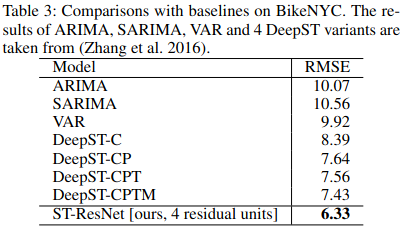